In [1]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

from torch import nn
from torchinfo import summary
import matplotlib.pyplot as plt

torch version: 2.0.0
torchvision version: 0.15.1


In [2]:
'''
Following cell contains code to train and test model, as it is general function, can be reused for almost any model of similar task
'''
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    '''
    Trains model for single epoch.

    Args:
    model: Model to be trained
    dataloader: Dataloader instance
    loss_fn: Loss function to calculate loss
    optimizer: Optimizer to minimize loss
    device: target device

    Returns:
    Tuple of (train_loss, train_accuracy)
    '''

    model.train()

    train_loss, train_acc = 0.00, 0.00

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss+=loss.item()

        optimizer.zero_grad()

        loss.backward()
        clip_value=5
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)

    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.
    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.
    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:
    (0.0223, 0.8985)
    """
    model.eval()
    test_loss, test_acc = 0.00, 0.00

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device)->Dict[str, int]:
    """Trains and tests a PyTorch model.
    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.
    Calculates, prints and stores evaluation metrics throughout.
    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [3]:
'''
This cell contains functionality to create custom dataloader
'''
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloader(
        train_dir: str,
        test_dir: str,
        transform: transforms.Compose,
        batch_size: int,
        num_workers: int=NUM_WORKERS
    ):
    """Creates training and testing DataLoaders.
        Takes in a training directory and testing directory path and turns
        them into PyTorch Datasets and then into PyTorch DataLoaders.

        Args:
            train_dir: Path to training directory.
            test_dir: Path to testing directory.
            transform: torchvision transforms to perform on training and testing data.
            batch_size: Number of samples per batch in each of the DataLoaders.
            num_workers: An integer for number of workers per DataLoader.

        Returns:
            A tuple of (train_dataloader, test_dataloader, class_names).
            Where class_names is a list of the target classes.
            Example usage:
            train_dataloader, test_dataloader, class_names = \
                = create_dataloaders(train_dir=path/to/train_dir,
                                    test_dir=path/to/test_dir,
                                    transform=some_transform,
                                    batch_size=32,
                                    num_workers=4)
    """
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [4]:
def set_seed(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [5]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
image_path = '/kaggle/input/covid-4-class-underbal-resized-test-train-only/kaggle/working/resizedImg/images'

train_dir = image_path+"/train"
test_dir = image_path+"/test"

train_dir, test_dir

('/kaggle/input/covid-4-class-underbal-resized-test-train-only/kaggle/working/resizedImg/images/train',
 '/kaggle/input/covid-4-class-underbal-resized-test-train-only/kaggle/working/resizedImg/images/test')

In [8]:
manual_transforms = transforms.Compose([
    transforms.ToTensor()
])
print(f"Manually created transform: {manual_transforms}")

Manually created transform: Compose(
    ToTensor()
)


In [9]:
BATCH_SIZE = 64 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7db45b1ba0b0>,
 ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

In [10]:
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 256, 256]), tensor(1))

(-0.5, 255.5, 255.5, -0.5)

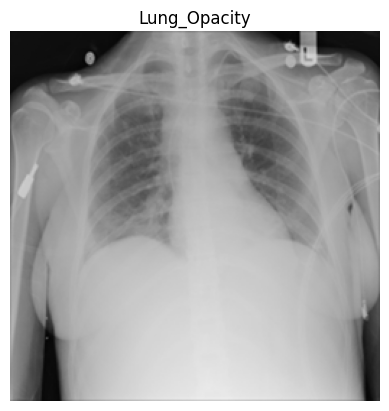

In [11]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [12]:
# Create example values
height = 256 # H ("The training resolution is 224.")
width = 256 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=256), width (W=256) and patch size (P=16): 256


In [13]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (256, 256, 3)
Output shape (single 2D image flattened into patches): (256, 768)


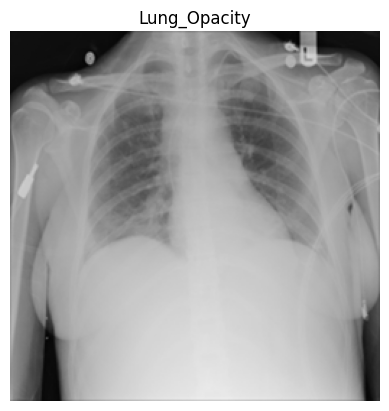

In [14]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

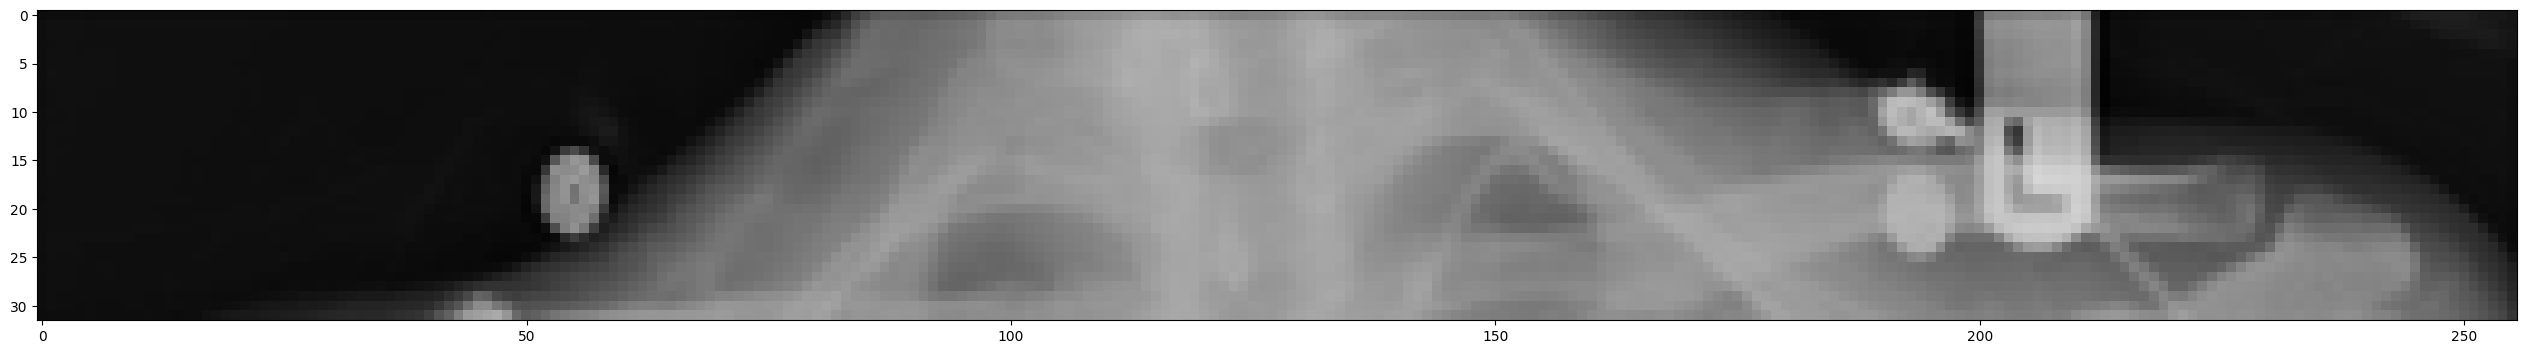

In [15]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 32
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 16.0
Patch size: 16 pixels x 16 pixels


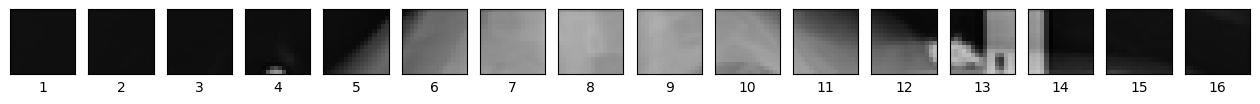

In [17]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 256
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [18]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 256
patch_size = 16
num_patches = img_size/patch_size 

In [19]:
# assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
# print(f"Number of patches per row: {num_patches}\
#         \nNumber of patches per column: {num_patches}\
#         \nTotal patches: {num_patches*num_patches}\
#         \nPatch size: {patch_size} pixels x {patch_size} pixels")

# # Create a series of subplots
# fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
#                         ncols=img_size // patch_size, 
#                         figsize=(num_patches, num_patches),
#                         sharex=True,
#                         sharey=True)

# # Loop through height and width of image
# for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
#     for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
#         # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
#         axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
#                                         patch_width:patch_width+patch_size, # iterate through width
#                                         :]) # get all color channels
        
#         # Set up label information, remove the ticks for clarity and set labels to outside
#         axs[i, j].set_ylabel(i+1, 
#                              rotation="horizontal", 
#                              horizontalalignment="right", 
#                              verticalalignment="center") 
#         axs[i, j].set_xlabel(j+1) 
#         axs[i, j].set_xticks([])
#         axs[i, j].set_yticks([])
#         axs[i, j].label_outer()

# # Set a super title
# fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
# plt.show()

Number of patches per row: 16.0        
Number of patches per column: 16.0        
Total patches: 256.0        
Patch size: 16 pixels x 16 pixels


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7db45b19a4d0> (for post_execute):


KeyboardInterrupt: 

In [20]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

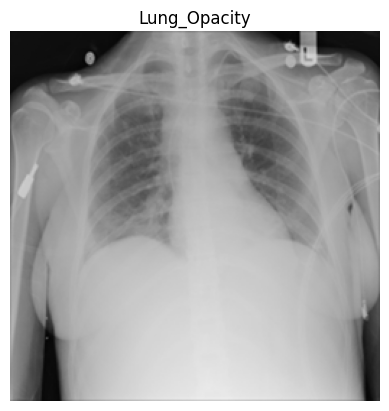

In [21]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [22]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 16, 16])


In [23]:
image_out_of_conv

tensor([[[[-0.0387, -0.0384, -0.0390,  ...,  0.0658, -0.0435, -0.0232],
          [-0.0351, -0.0367, -0.0716,  ..., -0.0803, -0.1096, -0.0352],
          [-0.1461, -0.0909, -0.0183,  ..., -0.0542, -0.0374, -0.0145],
          ...,
          [ 0.0208, -0.0065, -0.0780,  ..., -0.0339, -0.0030,  0.0146],
          [ 0.0121,  0.0074, -0.1343,  ..., -0.0352, -0.0197,  0.0372],
          [ 0.0189,  0.0301, -0.1697,  ..., -0.0403, -0.0311,  0.0878]],

         [[ 0.0199,  0.0213,  0.0237,  ...,  0.0497,  0.0173,  0.0138],
          [ 0.0155,  0.0205,  0.0904,  ...,  0.1138,  0.0987, -0.0416],
          [ 0.1382, -0.0043,  0.0260,  ...,  0.0497,  0.0584,  0.0378],
          ...,
          [ 0.0120, -0.0323,  0.0474,  ...,  0.0439,  0.0178,  0.0634],
          [-0.0145, -0.0232,  0.0345,  ...,  0.0433,  0.0214,  0.0686],
          [ 0.0064,  0.0094,  0.0750,  ...,  0.0533,  0.0374,  0.0673]],

         [[-0.0075, -0.0097, -0.0091,  ...,  0.2082, -0.0045,  0.0060],
          [-0.0085, -0.0286, -

Showing random convolutional feature maps from indexes: [346, 306, 342, 475, 220]


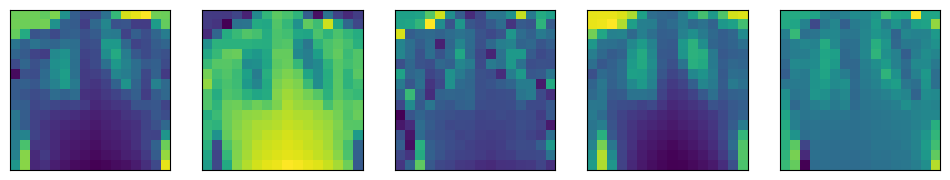

In [24]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [25]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0387, -0.0384, -0.0390,  0.0076, -0.1166, -0.0911, -0.0687,
           -0.0555, -0.0760, -0.0764, -0.0628, -0.0707, -0.0164,  0.0658,
           -0.0435, -0.0232],
          [-0.0351, -0.0367, -0.0716, -0.1497, -0.0768, -0.0143, -0.0394,
           -0.0609, -0.0379,  0.0027, -0.0686, -0.0393, -0.0420, -0.0803,
           -0.1096, -0.0352],
          [-0.1461, -0.0909, -0.0183, -0.0850, -0.0311, -0.0250, -0.0511,
           -0.0549, -0.0322, -0.0175, -0.0087, -0.0901, -0.0689, -0.0542,
           -0.0374, -0.0145],
          [-0.0892, -0.0635, -0.0473, -0.0564, -0.0029, -0.0044, -0.0118,
           -0.0502, -0.0272, -0.0290, -0.0017, -0.0588, -0.0459, -0.0488,
           -0.0360, -0.0524],
          [-0.0795, -0.0496, -0.0304, -0.0315, -0.0143, -0.0125, -0.0517,
           -0.0536, -0.0332, -0.0010,  0.0319, -0.0566, -0.0410, -0.0312,
           -0.0417, -0.0216],
          [-0.0754, -0.0072, -0.0393, -0.0239, -0.0271, -0.0170, -0.0786,
           -0.0714, -0.0365, -0.0444

In [26]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 16, 16]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [27]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 256, 256])
Image feature map shape: torch.Size([1, 768, 16, 16])
Flattened image feature map shape: torch.Size([1, 768, 256])


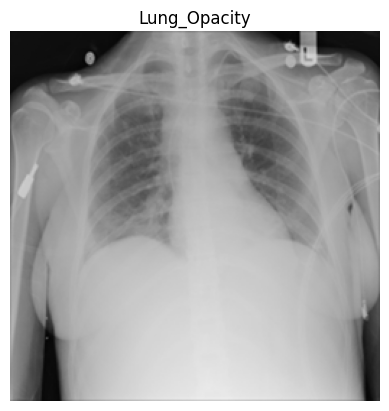

In [28]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [29]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 256, 768]) -> [batch_size, num_patches, embedding_size]


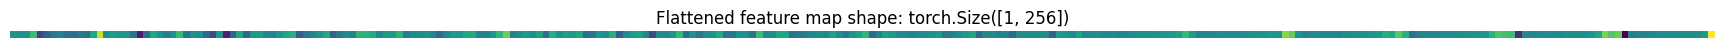

In [30]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [31]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.0387, -0.0384, -0.0390,  0.0076, -0.1166, -0.0911, -0.0687, -0.0555,
          -0.0760, -0.0764, -0.0628, -0.0707, -0.0164,  0.0658, -0.0435, -0.0232,
          -0.0351, -0.0367, -0.0716, -0.1497, -0.0768, -0.0143, -0.0394, -0.0609,
          -0.0379,  0.0027, -0.0686, -0.0393, -0.0420, -0.0803, -0.1096, -0.0352,
          -0.1461, -0.0909, -0.0183, -0.0850, -0.0311, -0.0250, -0.0511, -0.0549,
          -0.0322, -0.0175, -0.0087, -0.0901, -0.0689, -0.0542, -0.0374, -0.0145,
          -0.0892, -0.0635, -0.0473, -0.0564, -0.0029, -0.0044, -0.0118, -0.0502,
          -0.0272, -0.0290, -0.0017, -0.0588, -0.0459, -0.0488, -0.0360, -0.0524,
          -0.0795, -0.0496, -0.0304, -0.0315, -0.0143, -0.0125, -0.0517, -0.0536,
          -0.0332, -0.0010,  0.0319, -0.0566, -0.0410, -0.0312, -0.0417, -0.0216,
          -0.0754, -0.0072, -0.0393, -0.0239, -0.0271, -0.0170, -0.0786, -0.0714,
          -0.0365, -0.0444, -0.0084, -0.0875, -0.0429, -0.0299, -0.0222, -0.0536,
          -0.109

In [32]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [33]:
set_seed()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 256, 256])
Output patch embedding shape: torch.Size([1, 256, 768])


In [34]:
# Create random input sizes
random_input_image = (1, 3, 256, 256)
random_input_image_error = (1, 3, 40, 40) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
# summary(PatchEmbedding(), 
#         input_size=random_input_image, # try swapping this for "random_input_image_error" 
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [35]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [36]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0830,  0.0066, -0.0459,  ...,  0.0554, -0.0303,  0.0267],
         [-0.0761,  0.0045, -0.0445,  ...,  0.0532, -0.0303,  0.0249],
         ...,
         [-0.7783,  0.1930, -0.2237,  ...,  0.6279, -0.3695,  0.3117],
         [-0.6702,  0.1403, -0.2195,  ...,  0.5628, -0.3112,  0.2889],
         [-0.0990, -0.0625, -0.1082,  ...,  0.0272, -0.1277,  0.2187]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 257, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [37]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0830,  0.0066, -0.0459,  ...,  0.0554, -0.0303,  0.0267],
          [-0.0761,  0.0045, -0.0445,  ...,  0.0532, -0.0303,  0.0249],
          ...,
          [-0.7783,  0.1930, -0.2237,  ...,  0.6279, -0.3695,  0.3117],
          [-0.6702,  0.1403, -0.2195,  ...,  0.5628, -0.3112,  0.2889],
          [-0.0990, -0.0625, -0.1082,  ...,  0.0272, -0.1277,  0.2187]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 257, 768]))

In [38]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 257, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [39]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9170, 1.0066, 0.9541,  ..., 1.0554, 0.9697, 1.0267],
         [0.9239, 1.0045, 0.9555,  ..., 1.0532, 0.9697, 1.0249],
         ...,
         [0.2217, 1.1930, 0.7763,  ..., 1.6279, 0.6305, 1.3117],
         [0.3298, 1.1403, 0.7805,  ..., 1.5628, 0.6888, 1.2889],
         [0.9010, 0.9375, 0.8918,  ..., 1.0272, 0.8723, 1.2187]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 257, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [40]:
set_seed()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 256, 256])
Input image with batch dimension shape: torch.Size([1, 3, 256, 256])
Patching embedding shape: torch.Size([1, 256, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 257, 768])
Patch and position embedding shape: torch.Size([1, 257, 768])


In [41]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [42]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1 
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 257, 768])
Output shape MSA block: torch.Size([1, 257, 768])


In [43]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [44]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1 
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 257, 768])
Output shape MLP block: torch.Size([1, 257, 768])


In [45]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

In [46]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 257, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 257, 768]        [1, 257, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 257, 768]        [1, 257, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 257, 768]        [1, 257, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 257, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 257, 768]        [1, 257, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 257, 768]        [1, 257, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 257, 768]        [1, 257, 768]        --                   True
│    │    └─Linear (0)                     

In [47]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [48]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 257, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 257, 768]        [1, 257, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.79
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.79

In [49]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=256, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=4): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [50]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 64
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([64, 1, 768])


In [51]:
len(class_names)

4

In [52]:
# set_seed()

# # Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 256, 256) # (batch_size, color_channels, height, width)

# # Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# # Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.2568, -0.2850, -0.0399,  1.0702]], grad_fn=<AddmmBackward0>)

In [53]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(64, 3, 256, 256), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [64, 3, 256, 256]    [64, 4]              198,144              True
├─PatchEmbedding (patch_embedding)                           [64, 3, 256, 256]    [64, 256, 768]       --                   True
│    └─Conv2d (patcher)                                      [64, 3, 256, 256]    [64, 768, 16, 16]    590,592              True
│    └─Flatten (flatten)                                     [64, 768, 16, 16]    [64, 768, 256]       --                   --
├─Dropout (embedding_dropout)                                [64, 257, 768]       [64, 257, 768]       --                   --
├─Sequential (transformer_encoder)                           [64, 257, 768]       [64, 257, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [64, 257, 768]       [64, 257, 768]

In [55]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-5, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seed()

# Train the model and save the training results to a dictionary
results = train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3832 | train_acc: 0.2952 | test_loss: 1.3865 | test_acc: 0.2472
Epoch: 2 | train_loss: 1.3840 | train_acc: 0.2701 | test_loss: 1.3868 | test_acc: 0.2472
Epoch: 3 | train_loss: 1.3874 | train_acc: 0.2523 | test_loss: 1.3869 | test_acc: 0.2482
Epoch: 4 | train_loss: 1.3874 | train_acc: 0.2579 | test_loss: 1.3864 | test_acc: 0.2472


KeyboardInterrupt: 

In [98]:
torch.save(vit, 'ViT16-UnderBal_B64.pth')

In [99]:
torch.save(vit.state_dict(), 'WeighViT16-UnderBal_B64.pth')